# Classifying Names with a Character-Level RNN

Source http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

---
## Dataprep

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

In [5]:
def find_files(path): return glob.glob(path)

In [6]:
def unicode_to_ascii(s):
    # Turn a Unicode string to plain ASCII
    # http://stackoverflow.com/a/518232/2809427
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [10]:
def read_lines(filename):
    # Read a file and split into lines
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [11]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

---
## Text to Tensors

In [15]:
import torch

In [16]:
def letter_to_index(letter):
    # find letter index from all_letters, e.g. "a" = 0
    return all_letters.find(letter)

In [17]:
def letter_to_tensor(letter):
    # Just for demonstration, turn a letter into a <1 x n_letters> Tensor
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


In [18]:
def line_to_tensor(line):
    # Turn a line into a <line_length x 1 x n_letters>,
    # or an array of one-hot letter vectors
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

---
## Network Creation

![structure](assets/Z2xbySO.png)

In [20]:
import torch.nn as nn
from torch.autograd import Variable

In [21]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size , hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size , output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [22]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [25]:
# input = Variable(letter_to_tensor('A'))
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)

In [27]:
print(output)

Variable containing:

Columns 0 to 9 
-2.8956 -2.9265 -2.9336 -2.8087 -2.9325 -2.8955 -2.8903 -2.8370 -2.7958 -2.8188

Columns 10 to 17 
-3.0021 -2.9347 -2.8763 -3.0130 -2.9498 -2.8048 -2.8932 -2.8534
[torch.FloatTensor of size 1x18]



---
## Data Sampling

In [28]:
def category_from_output(output):
    # help interpret network output
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [29]:
category_from_output(output)

('Irish', 8)

In [30]:
import random
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

In [31]:
def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

In [34]:
for _ in range(10):
    print(random_training_example()[0:2])

('Russian', 'Janjul')
('Arabic', 'Hajjar')
('Irish', 'Faolan')
('Chinese', 'Chao')
('Arabic', 'Boutros')
('French', 'Sauveterre')
('Polish', 'Kozlowski')
('French', 'Samuel')
('Irish', "O'Rourke")
('Portuguese', 'Esteves')


---
## Training

In [35]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [37]:
def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add weight gradients x learning rate to weights
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.data[0]

In [38]:
from time import time
from math import floor

def time_since(since):
    now = time()
    s = now - since
    m = floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [41]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

In [42]:
start = time()

for iter in range(1, 1 + n_iters):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.2790 Hasegawa / Japanese ✓
10000 10% (0m 11s) 1.7307 Le / Chinese ✗ (Vietnamese)
15000 15% (0m 17s) 3.8471 Hoffman / Irish ✗ (German)
20000 20% (0m 23s) 2.0222 Bryson / Scottish ✗ (English)
25000 25% (0m 29s) 2.6553 Solomon / Russian ✗ (French)
30000 30% (0m 35s) 4.3616 Maus / Arabic ✗ (German)
35000 35% (0m 41s) 2.0302 Durand / French ✓
40000 40% (0m 47s) 1.1242 Cassano / Italian ✓
45000 45% (0m 54s) 1.3984 Accorso / Portuguese ✗ (Italian)
50000 50% (1m 0s) 3.4390 Rompa / Czech ✗ (Dutch)
55000 55% (1m 6s) 3.5572 Neil / Chinese ✗ (Irish)
60000 60% (1m 12s) 1.1649 Gaber / Arabic ✓
65000 65% (1m 18s) 0.2506 Belesis / Greek ✓
70000 70% (1m 26s) 2.7539 Gagnon / Scottish ✗ (French)
75000 75% (1m 32s) 0.9474 Kimura / Japanese ✓
80000 80% (1m 38s) 1.3871 Slattery / English ✓
85000 85% (1m 44s) 0.5188 Zhvanetsky / Russian ✓
90000 90% (1m 49s) 1.1127 Luong / Chinese ✗ (Vietnamese)
95000 95% (1m 55s) 2.7578 Bordelon / English ✗ (French)
100000 100% (2m 1s) 9.5450 Researcher / F

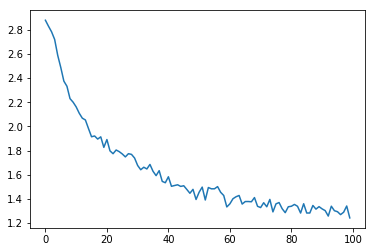

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

---
## Evaluation

In [51]:
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [63]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# score model on a bunch of examples
for i in range (n_confusion): 
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# normalize
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

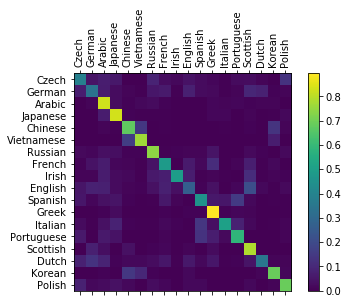

In [64]:
# plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

---
## Inference

In [52]:
def predict(input_line, n_predicitons=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))
    
    topv, topi = output.data.topk(n_predicitons, 1, True)
    predictions = []
    
    for i in range(n_predicitons):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [62]:
predict('Nawfal')


> Nawfal
(-0.93) Czech
(-1.20) Arabic
(-1.65) Polish


---
## Going Further

Change data
+ word -> language
+ first name -> gender
+ character name -> writer
+ page title -> blog/subreddit

Change network
+ add more linear layers
+ try LSTM and GRU layers
+ combine multiple RNNs to higher level net

---